<a href="https://www.kaggle.com/code/mmellinger66/s3e7-reservation-cancellation-models?scriptVersionId=119793498" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

 <div style="background-color:rgba(177, 156, 217, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Playground Season 3: Episode 7 - Reservation Cancellation </h1>
</div>

## Problem Type

Classification

## Evaluation Metric

AUC

<div style="background-color:rgba(177, 156, 217, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Import Libraries</h1>
</div>

In [1]:
# Black formatter https://black.readthedocs.io/en/stable/

! pip install nb-black > /dev/null

%load_ext lab_black

In [2]:
from typing import List, Set, Dict, Tuple, Optional

import os
import time
from pathlib import Path
import glob
import gc

import pandas as pd
import numpy as np

from sklearn import impute
from sklearn import metrics
from sklearn import preprocessing
from sklearn import linear_model
from sklearn import svm
from sklearn import cluster
from sklearn import decomposition
from sklearn import model_selection
from sklearn import ensemble
from sklearn import datasets

import xgboost as xgb
import catboost as cb
import lightgbm as lgb

import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances

from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

# Visualization Libraries
import matplotlib as mpl
import matplotlib.pylab as plt
import seaborn as sns
import missingno as msno
from folium import Map
from folium.plugins import HeatMap
from IPython.display import display_html, display_markdown, display_latex
from colorama import Fore, Style

import warnings

warnings.filterwarnings("ignore")

<div style="background-color:rgba(177, 156, 217, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Configuration</h1>
</div>

In [3]:
TARGET = "booking_status"
ID = "id"

In [4]:
class Config:
    path: str = "../input/playground-series-s3e7/"
    gpu: bool = False
    optimize: bool = False
    n_optuna_trials: int = 5
    fast_render: bool = False
    calc_probability: bool = False
    debug: bool = False
    seed: int = 42
    N_ESTIMATORS: int = 500  # 100, 300, 1000, 2000, 5000, 15_000, 20_000 GBDT
    GPU_N_ESTIMATORS: int = 1000  # Want models to run fast during dev
    N_FOLDS: int = 5

In [5]:
class clr:
    S = Style.BRIGHT + Fore.LIGHTRED_EX
    E = Style.RESET_ALL

<div style="background-color:rgba(177, 156, 217, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Library</h1>
</div>

In [6]:
def read_data(
    path: str, analyze: bool = True
) -> (pd.DataFrame, pd.DataFrame, pd.DataFrame):
    data_dir = Path(path)

    train = pd.read_csv(data_dir / "train.csv")
    test = pd.read_csv(data_dir / "test.csv")
    submission_df = pd.read_csv(data_dir / "sample_submission.csv")

    if analyze:
        print(clr.S + "=== Shape of Data ===" + clr.E)
        print(f" train data: Rows={train.shape[0]}, Columns={train.shape[1]}")
        print(f" test data : Rows={test.shape[0]}, Columns={test.shape[1]}")

        print(clr.S + "\n=== Train Data: First 5 Rows ===\n" + clr.E)
        display(train.head())
        print(f"\n{clr.S}=== Train Column Names ==={clr.E}\n")
        display(train.columns)
        print(f"\n{clr.S}=== Features/Explanatory Variables ==={clr.E}\n")
        eval_features(train)
        print(f"\n{clr.S}=== Skewness ==={clr.E}\n")
        check_skew(train)
    return train, test, submission_df


def create_submission(
    model_name: str, target, preds, seed: int = 42, nfolds: int = 5
) -> pd.DataFrame:
    sample_submission[target] = preds.astype(int)

    if len(model_name) > 0:
        fname = f"submission_{model_name}_k{nfolds}_s{seed}.csv"
    else:
        fname = "submission.csv"

    sample_submission.to_csv(fname, index=False)

    return sample_submission


def show_classification_scores(ground_truth: List[int], yhat: List[int]) -> None:
    accuracy = metrics.accuracy_score(ground_truth, yhat)
    precision = metrics.precision_score(ground_truth, yhat)
    recall = metrics.recall_score(ground_truth, yhat)
    roc = metrics.roc_auc_score(ground_truth, yhat)
    f1 = metrics.f1_score(ground_truth, yhat)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"ROC: {roc:.4f}")
    print(f"f1: {f1:.4f}")


def label_encoder(
    train: pd.DataFrame, test: pd.DataFrame, columns: List[str]
) -> (pd.DataFrame, pd.DataFrame):
    for col in columns:
        train[col] = train[col].astype(str)
        test[col] = test[col].astype(str)
        train[col] = preprocessing.LabelEncoder().fit_transform(train[col])
        test[col] = preprocessing.LabelEncoder().fit_transform(test[col])
    return train, test


def create_strat_folds(
    df: pd.DataFrame, TARGET, n_folds: int = 5, seed: int = 42
) -> pd.DataFrame:
    print(f"TARGET={TARGET}, n_folds={n_folds}, seed={seed}")
    df["fold"] = -1

    kf = model_selection.StratifiedKFold(
        n_splits=n_folds, shuffle=True, random_state=seed
    )
    # kf = GroupKFold(n_splits=Config.N_FOLDS)
    for fold, (train_idx, valid_idx) in enumerate(kf.split(df, df[TARGET])):
        df.loc[valid_idx, "fold"] = fold

    # df.to_csv(f"train_fold{num_folds}.csv", index=False)
    return df


def create_folds(df: pd.DataFrame, n_folds: int = 5, seed: int = 42) -> pd.DataFrame:
    print(f"n_folds={n_folds}, seed={seed}")
    df["fold"] = -1

    kf = model_selection.KFold(n_splits=n_folds, shuffle=True, random_state=seed)

    for fold, (train_idx, valid_idx) in enumerate(kf.split(df)):
        df.loc[valid_idx, "fold"] = fold

    # df.to_csv(f"train_fold{num_folds}.csv", index=False)
    return df


def show_fold_scores(scores: List[float]) -> (float, float):
    cv_score = np.mean(scores)  # Used in filename
    std_dev = np.std(scores)
    print(
        f"Scores -> Adjusted: {np.mean(scores) - np.std(scores):.8f} , mean: {np.mean(scores):.8f}, std: {np.std(scores):.8f}"
    )
    return cv_score, std_dev


def feature_distribution_types(
    df: pd.DataFrame, display: bool = True
) -> (List[str], List[str]):
    continuous_features = list(
        df.select_dtypes(include=["int64", "float64", "uint8"]).columns
    )
    categorical_features = list(df.select_dtypes(include=["object", "bool"]).columns)
    if display:
        print(f"{clr.S}Continuous Features={continuous_features}{clr.E}\n")
        print(f"{clr.S}Categorical Features={categorical_features}{clr.E}")
    return continuous_features, categorical_features


def show_cardinality(df: pd.DataFrame, features: List[str]) -> None:
    print("=== Cardinality ===")
    print(df[features].nunique())


## === Model Support ===

from scipy.stats import mode


def merge_test_predictions(
    final_test_predictions: List[float], calc_probability: bool = True
) -> List[float]:

    if calc_probability:
        print("Mean")
        result = np.mean(np.column_stack(final_test_predictions), axis=1)
    else:
        print("Mode")
        mode_result = mode(np.column_stack(final_test_predictions), axis=1)
        result = mode_result[0].ravel()

    return result


def summary_statistics(X: pd.DataFrame, enhanced=True) -> None:
    desc = X.describe()
    if enhanced:
        desc.loc["var"] = X.var(numeric_only=True).tolist()
        desc.loc["skew"] = X.skew(numeric_only=True).tolist()
        desc.loc["kurt"] = X.kurtosis(numeric_only=True).tolist()

    with pd.option_context("display.precision", 2):
        style = desc.transpose().style.background_gradient(
            cmap="coolwarm"
        )  # .set_precision(4)
    display(style)


def show_missing_features(df: pd.DataFrame) -> None:
    missing_vals = df.isna().sum().sort_values(ascending=False)
    print(missing_vals[missing_vals > 0])


def show_duplicate_records(df: pd.DataFrame) -> None:
    dups = df.duplicated()
    print(dups.sum())


def eval_features(df: pd.DataFrame) -> (List[str], List[str], List[str]):
    ## Separate Categorical and Numerical Features
    categorical_features = list(
        df.select_dtypes(include=["category", "object"]).columns
    )
    continuous_features = list(df.select_dtypes(include=["number"]).columns)

    print(f"{clr.S}Continuous features:{clr.E} {continuous_features}")
    print(f"{clr.S}Categorical features:{clr.E} {categorical_features}")
    print("\n --- Cardinality of Categorical Features ---\n")

    for feature in categorical_features:
        cardinality = df[feature].nunique()
        if cardinality < 10:
            print(
                f"{clr.S}{feature}{clr.E}: cardinality={cardinality}, {df[feature].unique()}"
            )
        else:
            print(f"{clr.S}{feature}{clr.E}: cardinality={cardinality}")
    all_features = categorical_features + continuous_features
    return all_features, categorical_features, continuous_features


def show_feature_importance(feature_importance_lst: List[str]) -> None:
    fis_df = pd.concat(feature_importance_lst, axis=1)

    fis_df.sort_values("0_importance", ascending=True).head(40).plot(
        kind="barh", figsize=(12, 12), title="Feature Importance Across Folds"
    )
    plt.show()


def show_feature_target_crosstab(
    df: pd.DataFrame, feature_lst: List[str], target: str
) -> None:
    for feature in feature_lst:
        print(f"\n=== {feature} vs {target} ===\n")
        display(
            pd.crosstab(df[feature], df[target], margins=True)
        )  # display keeps bold formatting


def show_cardinality(df: pd.DataFrame, features: List[str]) -> None:
    print(f"{clr.S}=== Cardinality ==={clr.E}")
    print(df[features].nunique())


def show_unique_features(df: pd.DataFrame, features: List[str]) -> None:
    for col in features:
        print(col, sorted(df[col].dropna().unique()))


def feature_distribution_types(
    df: pd.DataFrame, display: bool = True
) -> (List[str], List[str]):
    continuous_features = list(
        df.select_dtypes(include=["int64", "float64", "uint8"]).columns
    )
    categorical_features = list(df.select_dtypes(include=["object", "bool"]).columns)
    if display:
        print(f"{clr.S}Continuous Features={clr.E}{continuous_features}\n")
        print(f"{clr.S}Categorical Features={clr.E}{categorical_features}")
    return continuous_features, categorical_features


def describe(X: pd.DataFrame) -> None:
    "Deprecated: Use summary_statistics()"
    desc = X.describe()
    desc.loc["var"] = X.var(numeric_only=True).tolist()
    desc.loc["skew"] = X.skew(numeric_only=True).tolist()
    desc.loc["kurt"] = X.kurtosis(numeric_only=True).tolist()

    with pd.option_context("display.precision", 2):
        style = desc.transpose().style.background_gradient(
            cmap="coolwarm"
        )  # .set_precision(4)
    display(style)


def check_skew(df: pd.DataFrame) -> None:
    skew = df.skew(skipna=True, numeric_only=True).sort_values(ascending=False)
    print(skew)


def gpu_ify_lgbm(lgbm_dict):
    lgbm_dict["device"] = "gpu"
    lgbm_dict["boosting_type"] = "gbdt"
    lgbm_dict["gpu_platform_id"] = 0
    lgbm_dict["gpu_device_id"] = 0
    return lgbm_dict


def gpu_ify_cb(params):
    params["task_type"] = "GPU"
    return params

<div style="background-color:rgba(177, 156, 217, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Optuna Hyperparameter Optimization Library</h1>
</div>

In [7]:
def objective_xgb(trial, X_train, X_valid, y_train, y_valid):

    xgb_params = {
        #         "objective": trial.suggest_categorical("objective", ["multi:softmax"]),
        #         "eval_metric": "mlogloss",
        #         "objective": "multi:softmax",
        "eval_metric": "auc",  # auc, rmse, mae
        "objective": "binary:logistic",
        #         "enable_categorical": trial.suggest_categorical("use_label_encoder", [True]),
        "use_label_encoder": trial.suggest_categorical("use_label_encoder", [False]),
        "n_estimators": trial.suggest_int("n_estimators", 1000, 5000, 100),
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-2, 0.25),
        "subsample": trial.suggest_float("subsample", 0.1, 1, step=0.01),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1, step=0.01),
        "max_depth": trial.suggest_int("max_depth", 1, 20),  # 10
        "gamma": trial.suggest_float("gamma", 0, 100, step=0.1),
        "booster": trial.suggest_categorical("booster", ["gbtree"]),
        "tree_method": trial.suggest_categorical(
            "tree_method", ["hist"]
        ),  # hist, gpu_hist
        #         "predictor": "gpu_predictor",
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-8, 100),
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-8, 100),
        "random_state": trial.suggest_categorical("random_state", [42]),
        "n_jobs": trial.suggest_categorical("n_jobs", [4]),
        "min_child_weight": trial.suggest_loguniform("min_child_weight", 1e-1, 1e3),
        # "min_child_weight": trial.suggest_categorical("min_child_weight", [256]),
    }

    # Model loading and training
    model = xgb.XGBClassifier(**xgb_params)
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        early_stopping_rounds=5000,
        verbose=0,
    )

    print(f"Number of boosting rounds: {model.best_iteration}")
    #     oof = model.predict_proba(X_valid)[:, 1] # Probability
    oof = model.predict(X_valid)  # Classification: 0,1

    return metrics.accuracy_score(y_valid, oof)


def objective_lgbm(trial, X_train, X_valid, y_train, y_valid):

    params = {
        "boosting_type": "gbdt",
        # "objective": trial.suggest_categorical("objective", ["mae", "rmse"]),
        #         "objective": trial.suggest_categorical("objective", ["multi:softprob"]),
        #         "n_estimators": trial.suggest_categorical("n_estimators", [1_000]),
        #         "n_estimators": trial.suggest_categorical("n_estimators", [5000]),
        "n_estimators": trial.suggest_int("n_estimators", 700, 1000),
        "importance_type": "gain",
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-8, 10.0),
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-8, 10.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1, step=0.01),
        "num_leaves": trial.suggest_int("num_leaves", 2, 1000),
        "feature_fraction": trial.suggest_uniform("feature_fraction", 0.1, 1.0),
        "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.1, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 0, 15),
        "min_child_samples": trial.suggest_int("min_child_samples", 1, 300),
        "subsample": trial.suggest_float("subsample", 0.1, 1, step=0.01),
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-2, 0.25),
        "max_depth": trial.suggest_int("max_depth", 1, 100),
        "random_state": trial.suggest_categorical("random_state", [42]),
        "n_jobs": trial.suggest_categorical("n_jobs", [4]),
        #         'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-1, 1e3),
        # "min_child_weight": trial.suggest_categorical("min_child_weight", [256]),
    }
    if Config.gpu:
        params["device_type"] = "gpu"

    # Model loading and training
    model = lgb.LGBMClassifier(**params)
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        # eval_metric="mae",
        callbacks=[
            lgb.log_evaluation(500),
            lgb.early_stopping(500, False, True),
        ],
    )

    #     print(f"Number of boosting rounds: {model.best_iteration}")
    oof = model.predict(X_valid)

    #     return accuracy_score(y_valid, oof)
    return metrics.roc_auc_score(y_valid, oof)


def objective_cb(trial, X_train, X_valid, y_train, y_valid):

    cb_params = {
        "iterations": 10,  # 1000
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.1, 1.0),
        "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1, 100),
        "bagging_temperature": trial.suggest_loguniform(
            "bagging_temperature", 0.1, 20.0
        ),
        "random_strength": trial.suggest_float("random_strength", 1.0, 2.0),
        "depth": trial.suggest_int("depth", 1, 10),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 300),
        "use_best_model": True,
        #         "task_type": "GPU",
        "random_seed": 42,
    }

    # Model loading and training
    model = cb.CatBoostClassifier(**cb_params)
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        # eval_metric="accuracy",
        early_stopping_rounds=500,
        verbose=False,
    )

    # print(f"Number of boosting rounds: {model.best_iteration}")
    # oof = model.predict_proba(X_valid)[:, 1]
    oof = model.predict(X_valid)  # Classification

    return metrics.accuracy_score(y_valid, oof)

<div style="background-color:rgba(177, 156, 217, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Load Train/Test Data and Analyze</h1>
</div>

## Load the following files

 - train.csv - Data used to build our machine learning model
 - test.csv - Data used to build our machine learning model. Does not contain the target variable
 - sample_submission.csv - A file in the proper format to submit test predictions

In [8]:
%%time
train, test, sample_submission = read_data(Config.path, analyze=True)

=== Shape of Data ===
 train data: Rows=42100, Columns=19
 test data : Rows=28068, Columns=18

=== Train Data: First 5 Rows ===



,id,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,0,2,0,0,2,1,0,0,9,2018,1,14,1,1,11,0,67.50,0,0
1,1,2,0,1,2,0,0,0,117,2018,7,29,0,0,0,0,72.25,0,0
2,2,2,0,0,1,0,0,0,315,2018,12,2,0,0,0,0,52.00,0,0
3,3,1,0,0,2,1,0,0,32,2018,12,1,1,0,0,0,56.00,0,0
4,4,2,0,1,0,0,0,0,258,2018,10,16,0,0,0,0,100.00,0,1



=== Train Column Names ===



Index(['id', 'no_of_adults', 'no_of_children', 'no_of_weekend_nights',
       'no_of_week_nights', 'type_of_meal_plan', 'required_car_parking_space',
       'room_type_reserved', 'lead_time', 'arrival_year', 'arrival_month',
       'arrival_date', 'market_segment_type', 'repeated_guest',
       'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled',
       'avg_price_per_room', 'no_of_special_requests', 'booking_status'],
      dtype='object')


=== Features/Explanatory Variables ===

Continuous features: ['id', 'no_of_adults', 'no_of_children', 'no_of_weekend_nights', 'no_of_week_nights', 'type_of_meal_plan', 'required_car_parking_space', 'room_type_reserved', 'lead_time', 'arrival_year', 'arrival_month', 'arrival_date', 'market_segment_type', 'repeated_guest', 'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled', 'avg_price_per_room', 'no_of_special_requests', 'booking_status']
Categorical features: []

 --- Cardinality of Categorical Features ---


=== Skewness ===

no_of_previous_cancellations            27.386688
no_of_previous_bookings_not_canceled    16.856332
required_car_parking_space               6.052554
repeated_guest                           5.593549
no_of_children                           3.574864
room_type_reserved                       2.567605
type_of_meal_plan                        2.309319
no_of_week_nights                        1.396208
market_segment_type                      1.3341

In [9]:
train.head()

,id,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,0,2,0,0,2,1,0,0,9,2018,1,14,1,1,11,0,67.50,0,0
1,1,2,0,1,2,0,0,0,117,2018,7,29,0,0,0,0,72.25,0,0
2,2,2,0,0,1,0,0,0,315,2018,12,2,0,0,0,0,52.00,0,0
3,3,1,0,0,2,1,0,0,32,2018,12,1,1,0,0,0,56.00,0,0
4,4,2,0,1,0,0,0,0,258,2018,10,16,0,0,0,0,100.00,0,1


In [10]:
original = pd.read_csv(
    "/kaggle/input/reservation-cancellation-prediction/train__dataset.csv"
)

In [11]:
train["is_original"] = 0
test["is_original"] = 0
original["is_original"] = 1

<AxesSubplot:xlabel='booking_status', ylabel='count'>

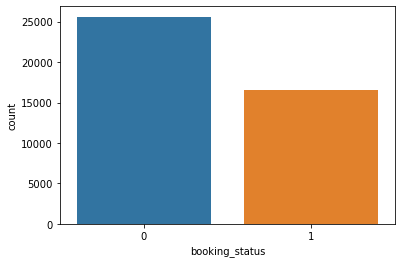

In [12]:
sns.countplot(data=train, x=TARGET)

In [13]:
summary_statistics(train.drop(columns=[ID], axis=1), enhanced=True)

,count,mean,std,min,25%,50%,75%,max,var,skew,kurt
no_of_adults,42100.00,1.92,0.52,0.00,2.00,2.00,2.00,4.00,0.28,-0.24,1.10
no_of_children,42100.00,0.14,0.45,0.00,0.00,0.00,0.00,9.00,0.20,3.57,17.08
no_of_weekend_nights,42100.00,0.88,0.89,0.00,0.00,1.00,2.00,7.00,0.78,0.55,-0.18
no_of_week_nights,42100.00,2.40,1.43,0.00,1.00,2.00,3.00,17.00,2.04,1.40,6.18
type_of_meal_plan,42100.00,0.24,0.59,0.00,0.00,0.00,0.00,3.00,0.35,2.31,3.86
required_car_parking_space,42100.00,0.03,0.16,0.00,0.00,0.00,0.00,1.00,0.02,6.05,34.64
room_type_reserved,42100.00,0.43,0.83,0.00,0.00,0.00,1.00,6.00,0.69,2.57,7.56
lead_time,42100.00,103.89,81.07,0.00,37.00,93.00,155.00,443.00,6572.24,0.82,0.37
arrival_year,42100.00,2017.86,0.35,2017.00,2018.00,2018.00,2018.00,2018.00,0.12,-2.03,2.13
arrival_month,42100.00,7.59,2.83,1.00,6.00,8.00,10.00,12.00,8.01,-0.38,-0.69


In [14]:
# train = pd.concat([train, original], axis=0)

<div style="background-color:rgba(177, 156, 217, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Feature Engineering</h1>
</div>

## Categorical/Numerical Variables

In [15]:
cont_features, cat_features = feature_distribution_types(train, display=True)
show_cardinality(train, cat_features)

cont_features.remove(TARGET)
cont_features.remove(ID)
FEATURES = cont_features + cat_features
FEATURES

Continuous Features=['id', 'no_of_adults', 'no_of_children', 'no_of_weekend_nights', 'no_of_week_nights', 'type_of_meal_plan', 'required_car_parking_space', 'room_type_reserved', 'lead_time', 'arrival_year', 'arrival_month', 'arrival_date', 'market_segment_type', 'repeated_guest', 'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled', 'avg_price_per_room', 'no_of_special_requests', 'booking_status', 'is_original']

Categorical Features=[]
=== Cardinality ===
Series([], dtype: float64)


['no_of_adults',
 'no_of_children',
 'no_of_weekend_nights',
 'no_of_week_nights',
 'type_of_meal_plan',
 'required_car_parking_space',
 'room_type_reserved',
 'lead_time',
 'arrival_year',
 'arrival_month',
 'arrival_date',
 'market_segment_type',
 'repeated_guest',
 'no_of_previous_cancellations',
 'no_of_previous_bookings_not_canceled',
 'avg_price_per_room',
 'no_of_special_requests',
 'is_original']

In [16]:
#  https://www.kaggle.com/competitions/playground-series-s3e7/discussion/386655

train["arrival_year_month"] = pd.to_datetime(
    train["arrival_year"].astype(str) + train["arrival_month"].astype(str),
    format="%Y%m",
)
test["arrival_year_month"] = pd.to_datetime(
    test["arrival_year"].astype(str) + test["arrival_month"].astype(str), format="%Y%m"
)
original["arrival_year_month"] = pd.to_datetime(
    original["arrival_year"].astype(str) + original["arrival_month"].astype(str),
    format="%Y%m",
)

train.loc[
    train.arrival_date > train.arrival_year_month.dt.days_in_month, "arrival_date"
] = train.arrival_year_month.dt.days_in_month
test.loc[
    test.arrival_date > test.arrival_year_month.dt.days_in_month, "arrival_date"
] = test.arrival_year_month.dt.days_in_month
original.loc[
    original.arrival_date > original.arrival_year_month.dt.days_in_month, "arrival_date"
] = original.arrival_year_month.dt.days_in_month

train.drop(columns="arrival_year_month", inplace=True)
test.drop(columns="arrival_year_month", inplace=True)
original.drop(columns="arrival_year_month", inplace=True)

In [17]:
excluded_features = [TARGET, ID, "fold"]

cont_features, cat_features = feature_distribution_types(train, display=True)
show_cardinality(train, cat_features)

cont_features = [
    feature for feature in cont_features if feature not in excluded_features
]
cat_features = [feature for feature in cat_features if feature not in excluded_features]

FEATURES = cont_features + cat_features
FEATURES

Continuous Features=['id', 'no_of_adults', 'no_of_children', 'no_of_weekend_nights', 'no_of_week_nights', 'type_of_meal_plan', 'required_car_parking_space', 'room_type_reserved', 'lead_time', 'arrival_year', 'arrival_month', 'arrival_date', 'market_segment_type', 'repeated_guest', 'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled', 'avg_price_per_room', 'no_of_special_requests', 'booking_status', 'is_original']

Categorical Features=[]
=== Cardinality ===
Series([], dtype: float64)


['no_of_adults',
 'no_of_children',
 'no_of_weekend_nights',
 'no_of_week_nights',
 'type_of_meal_plan',
 'required_car_parking_space',
 'room_type_reserved',
 'lead_time',
 'arrival_year',
 'arrival_month',
 'arrival_date',
 'market_segment_type',
 'repeated_guest',
 'no_of_previous_cancellations',
 'no_of_previous_bookings_not_canceled',
 'avg_price_per_room',
 'no_of_special_requests',
 'is_original']

<div style="background-color:rgba(177, 156, 217, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Optuna Hyperparameter Optimization
</h1>
</div>

In [18]:
y = train[TARGET]
X = train[FEATURES].copy()

X_test = test[FEATURES].copy()

In [19]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(
    X, y, test_size=0.2, random_state=Config.seed
)

In [20]:
# === XGB ===

time_limit = 3600 * 3
best_xgb_params = {}

if Config.optimize:
    study = optuna.create_study(direction="maximize")
    study.optimize(
        lambda trial: objective_xgb(trial, X_train, X_valid, y_train, y_valid),
        n_trials=Config.n_optuna_trials,
        # timeout=time_limit,  # this or n_trials
    )

if Config.optimize:
    print("Number of finished trials:", len(study.trials))
    print("Best trial parameters:", study.best_trial.params)
    print("Best score:", study.best_value)
    best_xgb_params = study.best_trial.params

## === LGBM ===

time_limit = 3600 * 3
best_lgbm_params = {}

if Config.optimize:
    study = optuna.create_study(direction="maximize")
    study.optimize(
        lambda trial: objective_lgbm(trial, X_train, X_valid, y_train, y_valid),
        n_trials=Config.n_optuna_trials,
        # timeout=time_limit,  # this or n_trials
    )

if Config.optimize:
    print("Number of finished trials:", len(study.trials))
    print("Best trial parameters:", study.best_trial.params)
    print("Best score:", study.best_value)
    best_lgbm_params = study.best_trial.params

## === CatBoost

time_limit = 3600 * 3
best_cb_params = {}

if Config.optimize:
    study = optuna.create_study(direction="maximize")
    study.optimize(
        lambda trial: objective_cb(trial, X_train, X_valid, y_train, y_valid),
        n_trials=Config.n_optuna_trials,
        # timeout=time_limit,  # this or n_trials
    )

if Config.optimize:
    print("Number of finished trials:", len(study.trials))
    print("Best trial parameters:", study.best_trial.params)
    print("Best score:", study.best_value)
    best_cb_params = study.best_trial.params

<div style="background-color:rgba(177, 156, 217, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Train Models with Cross Validation</h1>
</div>

In [21]:
# train = create_folds(train, Config.N_FOLDS)
train = create_strat_folds(train, TARGET, Config.N_FOLDS)

TARGET=booking_status, n_folds=5, seed=42


In [22]:
all_cv_scores = pd.DataFrame(
    {
        "Model": pd.Series(dtype="str"),
        "Score": pd.Series(dtype="float"),
        "StdDev": pd.Series(dtype="float"),
        "RunTime": pd.Series(dtype="float"),
    }
)

oof = train[[ID, TARGET, "fold"]].copy().reset_index(drop=True).copy()
oof.set_index(ID, inplace=True)
oof.head()

,booking_status,fold
id,,
0,0,1
1,0,4
2,0,3
3,0,4
4,1,0


In [23]:
def show_tree_model_fi(model, features: List[str]) -> None:
    print("\n=== Model Feature Importance ===")
    for i in model.feature_importances_.argsort()[::-1]:
        print(
            features[i],
            model.feature_importances_[i] / model.feature_importances_.sum(),
        )


def save_oof_predictions(
    model_name: str, final_valid_predictions, oof: pd.DataFrame
) -> pd.DataFrame:
    final_valid_predictions_df = process_valid_predictions(
        final_valid_predictions, ID, model_name
    )
    display(final_valid_predictions_df.head())
    oof[f"pred_{model_name}"] = final_valid_predictions_df[f"pred_{model_name}"]

    return oof


def save_test_predictions(
    model_name: str,
    final_test_predictions,
    submission_df: pd.DataFrame,
    result_field: str = TARGET,
) -> None:
    result = merge_test_predictions(final_test_predictions, Config.calc_probability)
    # result[:20]
    submission_df[f"target_{model_name}"] = result.astype(int)
    #     submission_df.head(10)
    ss = submission_df[[ID, f"target_{model_name}"]].copy().reset_index(drop=True)
    ss.rename(columns={f"target_{model_name}": result_field}, inplace=True)
    ss.to_csv(
        f"submission_{model_name}.csv", index=False
    )  # Can submit the individual model
    print("=== Target Value Counts ===")
    display(ss[TARGET].value_counts())
    ss.head(10)


def process_valid_predictions(
    final_valid_predictions, train_id, model_name: str
) -> pd.DataFrame:
    model = f"pred_{model_name}"
    final_valid_predictions_df = pd.DataFrame.from_dict(
        final_valid_predictions, orient="index"
    ).reset_index()
    final_valid_predictions_df.columns = [train_id, model]
    final_valid_predictions_df.set_index(train_id, inplace=True)
    final_valid_predictions_df.sort_index(inplace=True)
    final_valid_predictions_df.to_csv(f"train_pred_{model_name}.csv", index=True)

    return final_valid_predictions_df


def add_score(score_df: pd.DataFrame, model_name: str, score: float, std: float):
    dict1 = {"Model": model_name, "Score": cv_score, "StdDev": std_dev}
    score_df = score_df.append(dict1, ignore_index=True)
    return score_df

In [24]:
def train_cv_model(
    df: pd.DataFrame,
    test: pd.DataFrame,
    get_model_fn,
    FEATURES: List[str],
    TARGET: str,
    calc_probability: bool,
    rowid,
    params,
    n_folds: int = 5,
    seed: int = 42,
):

    final_test_predictions = []
    final_valid_predictions = {}
    fold_scores = []  # Scores of Validation Set
    feature_importance_lst = []

    test = test[FEATURES].copy()

    for fold in range(n_folds):
        print(10 * "=", f"Fold {fold+1}/{n_folds}", 10 * "=")

        start_time = time.time()

        xtrain = df[df.fold != fold].reset_index(
            drop=True
        )  # Everything not in validation fold
        xvalid = df[df.fold == fold].reset_index(drop=True)
        xtest = test.copy()

        valid_ids = xvalid.id.values.tolist()  # Id's of everything in validation fold

        ytrain = xtrain[TARGET]
        yvalid = xvalid[TARGET]

        xtrain = xtrain[FEATURES]
        xvalid = xvalid[FEATURES]

        scaler = preprocessing.StandardScaler()
        #         scaler = preprocessing.MinMaxScaler()
        xtrain = scaler.fit(xtrain).transform(xtrain)
        xvalid = scaler.transform(xvalid)
        xtest = scaler.transform(xtest)

        model = get_model_fn  # ()

        model.fit(
            xtrain,
            ytrain,
        )
        if calc_probability:
            preds_valid = model.predict_proba(xvalid)[:, 1]
            test_preds = model.predict_proba(xtest)[:, 1]
        else:
            preds_valid = model.predict(xvalid)
            test_preds = model.predict(xtest)

        preds_valid_class = model.predict(xvalid)

        final_test_predictions.append(test_preds)
        final_valid_predictions.update(dict(zip(valid_ids, preds_valid)))

        # fold_score = metrics.accuracy_score(yvalid, preds_valid_class)  # Validation Set Score
        #         fold_score = metrics.roc_auc_score(yvalid.values, preds_valid)  # Validation Set Score
        #         show_classification_scores(yvalid.values, preds_valid_class)

        #         fold_score = metrics.roc_auc_score(yvalid, preds_valid)  # Validation Set Score
        #         fold_score = metrics.mean_squared_error(yvalid, preds_valid, squared=False)
        fold_scores.append(fold_score)
        #         importance_list.append(model.coef_.ravel())

        fi = []
        # Feature importance
        #         fi = pd.DataFrame(
        #             index=FEATURES,
        #             data=model.coef_.ravel(),
        #             columns=[f"{fold}_importance"],
        #         )

        feature_importance_lst.append(fi)

        run_time = time.time() - start_time

        print(f"fold: {fold+1}, Score: {fold_score}, Run Time: {run_time:.2f}")

    return (
        model,
        feature_importance_lst,
        fold_scores,
        final_valid_predictions,
        final_test_predictions,
    )


def train_xgb_model(
    df: pd.DataFrame,
    test: pd.DataFrame,
    get_model_fn,
    FEATURES: List[str],
    TARGET: str,
    calc_probability: bool,
    rowid: str,
    params,
    n_folds: int = 5,
    seed: int = 42,
):

    print(params)
    final_test_predictions = []
    final_valid_predictions = {}
    fold_scores = []  # Scores of Validation Set
    feature_importance_lst = []

    test = test[FEATURES].copy()

    for fold in range(n_folds):
        print(10 * "=", f"Fold {fold+1}/{n_folds}", 10 * "=")

        start_time = time.time()

        xtrain = df[df.fold != fold].reset_index(
            drop=True
        )  # Everything not in validation fold
        xvalid = df[df.fold == fold].reset_index(drop=True)
        xtest = test.copy()

        valid_ids = xvalid.id.values.tolist()  # Id's of everything in validation fold

        ytrain = xtrain[TARGET]
        yvalid = xvalid[TARGET]

        xtrain = xtrain[FEATURES]
        xvalid = xvalid[FEATURES]

        model = get_model_fn  # (params)

        model.fit(
            xtrain,
            ytrain,
            eval_set=[(xvalid, yvalid)],
            #             eval_metric="acc",  # auc
            verbose=0,
            #             early_stopping_rounds=3000,
            #             callbacks=[
            #                 xgb.log_evaluation(0),
            #                 xgb.early_stopping(500, False, True),
            #             ],
        )

        if calc_probability:
            preds_valid = model.predict_proba(xvalid)[:, 1]
            test_preds = model.predict_proba(xtest)[:, 1]
        else:
            preds_valid = model.predict(xvalid)
            test_preds = model.predict(xtest)

        preds_valid_class = model.predict(xvalid)

        final_test_predictions.append(test_preds)
        if Config.debug:
            print(f"GT Type: {type(yvalid.values)}")
            print(f"Preds Type: {type(preds_valid_class)}")
            print(f"         GT:{yvalid.values[:20]}")
            print(f"Preds Class:{preds_valid_class[:20]}")
            print(f"Preds Prob:{preds_valid[:20]}")
        final_valid_predictions.update(dict(zip(valid_ids, preds_valid_class)))

        #         fold_score = metrics.cohen_kappa_score(yvalid,  preds_valid_class, weights = "quadratic")
        fold_score = metrics.roc_auc_score(
            yvalid.values, preds_valid
        )  # Validation Set Score
        show_classification_scores(yvalid.values, preds_valid_class)
        #         fold_score = metrics.mean_absolute_error(
        #             yvalid, preds_valid
        #         )  # Validation Set Score
        #         fold_score = metrics.mean_squared_error(yvalid, preds_valid, squared=False)
        fold_scores.append(fold_score)

        # Feature importance
        fi = pd.DataFrame(
            index=FEATURES,
            data=model.feature_importances_,
            columns=[f"{fold}_importance"],
        )
        feature_importance_lst.append(fi)

        run_time = time.time() - start_time

        print(f"fold: {fold+1}, Score: {fold_score}, Run Time: {run_time:.2f}")

    return (
        model,
        feature_importance_lst,
        fold_scores,
        final_valid_predictions,
        final_test_predictions,
    )

In [25]:
def run_linear_model(
    model_dict, model_name: str, features: List[str], oof: pd.DataFrame
) -> (float, float, pd.DataFrame):
    (
        model,
        feature_importance_lst,
        fold_scores,
        final_valid_predictions,
        final_test_predictions,
    ) = train_cv_model(
        train,
        test,
        model_dict[model_name],
        features,
        TARGET,
        False,  # Config.calc_probability,
        ID,
        {},
        Config.N_FOLDS,
        Config.seed,
    )

    cv_score, std_dev = show_fold_scores(fold_scores)

    oof = save_oof_predictions(model_name, final_valid_predictions, oof)
    oof.head()
    save_test_predictions(model_name, final_test_predictions, sample_submission, TARGET)

    return cv_score, std_dev, oof


def run_tree_model(
    model_dict, model_name: str, features: List[str], params, oof: pd.DataFrame
) -> (float, float, pd.DataFrame):
    (
        model,
        feature_importance_lst,
        fold_scores,
        final_valid_predictions,
        final_test_predictions,
    ) = train_xgb_model(
        train,
        test,
        model_dict[model_name],
        features,
        TARGET,
        Config.calc_probability,
        ID,
        params,
        Config.N_FOLDS,
        Config.seed,
    )

    cv_score, std_dev = show_fold_scores(fold_scores)
    show_tree_model_fi(model, features)

    oof = save_oof_predictions(model_name, final_valid_predictions, oof)
    oof.head()
    save_test_predictions(model_name, final_test_predictions, sample_submission, TARGET)

    return cv_score, std_dev, oof

In [26]:
%%time

def run_models4features(model_dict, model_lst:List[str], target:str, feature_lst:List[str], all_cv_scores:pd.DataFrame, linear_models:bool=True) -> pd.DataFrame:

    oof = train[[ID, target, "fold"]].copy().reset_index(drop=True).copy()
    oof.set_index(ID, inplace=True)

    for idx, m in enumerate(model_lst):
        model = model_lst[idx]
        start_time = time.time()

        print(f"Model={model}")

        params = {}
        if linear_models:
                cv_score, std_dev, oof = run_linear_model(model_dict, model, feature_lst, oof)

        else:
            cv_score, std_dev, oof = run_tree_model(model_dict, model, feature_lst, params, oof)

        run_time = time.time() - start_time

        score_dict = {"Model": model, "Score": cv_score, "StdDev": std_dev, "RunTime": run_time}
        all_cv_scores = all_cv_scores.append(score_dict, ignore_index=True)
        print(f"Model Run Time: {run_time:.2f}")

    return all_cv_scores

CPU times: user 12 µs, sys: 3 µs, total: 15 µs
Wall time: 18.1 µs


In [27]:
lgbm_params = {
    "objective": "binary",
    "metric": "auc",
    "n_estimators": Config.N_ESTIMATORS,
    "learning_rate": 0.05,
}

In [28]:
xgb_params = {
    "objective": "binary:logistic",
    "eval_metric": "auc",
}

xgb_params2 = {
    "max_depth": 9,
    "learning_rate": 0.11606271806831454,
    "n_estimators": 253,
    "min_child_weight": 5,
    "gamma": 3.470391330493054e-05,
    "subsample": 0.8846666091808068,
    "colsample_bytree": 0.3719532518081895,
    "reg_alpha": 2.5181566737563785e-05,
    "reg_lambda": 0.026556795784681893,
}

In [29]:
cb_params = {
    "iterations": Config.N_ESTIMATORS,
    "objective": "Logloss",  # "binary",
    #     "eval_metric": "AUC",  # accuracy
    "random_seed": Config.seed,
}

In [30]:
model_estimator_dict = {
    "xgb1": xgb.XGBClassifier(**xgb_params),
    "xgb2": xgb.XGBClassifier(**xgb_params2),
    "lgbm1": lgb.LGBMClassifier(**lgbm_params),
    #     "lgbm2": lgb.LGBMClassifier(**lgb_params_best_bsmith),
    #     "lgbm3": lgb.LGBMClassifier(**lgbm_params03),
    "cat1": cb.CatBoostClassifier(**cb_params),
    #     "cat2": cb.CatBoostClassifier(**cb_params2),
    #     "cat3": cb.CatBoostClassifier(**cb_params3),
}

In [31]:
%%time

model_lst = ['xgb2',"xgb1","lgbm1",  "cat1",]
# model_lst = ["lgbm1", "lgbm2", "lgbm3", "cat1", "cat2", "cat3"]
# model_lst = ["lgbm1"]
# model_lst = = []
all_cv_scores = run_models4features(model_estimator_dict, model_lst, TARGET, FEATURES, all_cv_scores, linear_models=False)    

all_cv_scores.sort_values(by=["Score"], ascending=False)

Model=xgb2
{}
========== Fold 1/5 ==========
Accuracy: 0.8246
Precision: 0.7800
Recall: 0.7694
ROC: 0.8148
f1: 0.7747
fold: 1, Score: 0.8147750946969696, Run Time: 5.31
========== Fold 2/5 ==========
Accuracy: 0.8273
Precision: 0.7910
Recall: 0.7604
ROC: 0.8154
f1: 0.7754
fold: 2, Score: 0.8154290799303744, Run Time: 4.75
========== Fold 3/5 ==========
Accuracy: 0.8175
Precision: 0.7777
Recall: 0.7483
ROC: 0.8052
f1: 0.7627
fold: 3, Score: 0.8051702707905677, Run Time: 5.07
========== Fold 4/5 ==========
Accuracy: 0.8234
Precision: 0.7868
Recall: 0.7537
ROC: 0.8110
f1: 0.7699
fold: 4, Score: 0.811022327792717, Run Time: 5.16
========== Fold 5/5 ==========
Accuracy: 0.8299
Precision: 0.7932
Recall: 0.7658
ROC: 0.8185
f1: 0.7793
fold: 5, Score: 0.8185462277705781, Run Time: 4.97
Scores -> Adjusted: 0.80840543 , mean: 0.81298860, std: 0.00458317

=== Model Feature Importance ===
market_segment_type 0.20403206
repeated_guest 0.18577164
no_of_special_requests 0.18560459
no_of_previous_booki

,pred_xgb2
id,
0,0
1,0
2,0
3,0
4,1


Mode
=== Target Value Counts ===


0    17545
1    10523
Name: booking_status, dtype: int64

Model Run Time: 25.94
Model=xgb1
{}
========== Fold 1/5 ==========
Accuracy: 0.8261
Precision: 0.7809
Recall: 0.7733
ROC: 0.8167
f1: 0.7771
fold: 1, Score: 0.8167447916666667, Run Time: 2.11
========== Fold 2/5 ==========
Accuracy: 0.8272
Precision: 0.7904
Recall: 0.7610
ROC: 0.8154
f1: 0.7754
fold: 2, Score: 0.8154389924522212, Run Time: 2.63
========== Fold 3/5 ==========
Accuracy: 0.8208
Precision: 0.7832
Recall: 0.7507
ROC: 0.8083
f1: 0.7666
fold: 3, Score: 0.8083355313487498, Run Time: 2.07
========== Fold 4/5 ==========
Accuracy: 0.8215
Precision: 0.7865
Recall: 0.7477
ROC: 0.8084
f1: 0.7666
fold: 4, Score: 0.8083836440667284, Run Time: 2.12
========== Fold 5/5 ==========
Accuracy: 0.8252
Precision: 0.7868
Recall: 0.7601
ROC: 0.8136
f1: 0.7732
fold: 5, Score: 0.8136171301160228, Run Time: 2.03
Scores -> Adjusted: 0.80897723 , mean: 0.81250402, std: 0.00352678

=== Model Feature Importance ===
no_of_special_requests 0.22369905
market_segment_type 0.21905962
required_car_parking_sp

,pred_xgb1
id,
0,0
1,0
2,0
3,0
4,1


Mode
=== Target Value Counts ===


0    17623
1    10445
Name: booking_status, dtype: int64

Model Run Time: 11.62
Model=lgbm1
{}
========== Fold 1/5 ==========
Accuracy: 0.8260
Precision: 0.7819
Recall: 0.7712
ROC: 0.8163
f1: 0.7765
fold: 1, Score: 0.8162701231060606, Run Time: 1.87
========== Fold 2/5 ==========
Accuracy: 0.8280
Precision: 0.7922
Recall: 0.7610
ROC: 0.8161
f1: 0.7763
fold: 2, Score: 0.8161227197427077, Run Time: 1.90
========== Fold 3/5 ==========
Accuracy: 0.8197
Precision: 0.7789
Recall: 0.7543
ROC: 0.8081
f1: 0.7664
fold: 3, Score: 0.8081019804981933, Run Time: 1.88
========== Fold 4/5 ==========
Accuracy: 0.8227
Precision: 0.7881
Recall: 0.7492
ROC: 0.8096
f1: 0.7681
fold: 4, Score: 0.8096293669614996, Run Time: 1.87
========== Fold 5/5 ==========
Accuracy: 0.8261
Precision: 0.7891
Recall: 0.7595
ROC: 0.8143
f1: 0.7740
fold: 5, Score: 0.8142909448846624, Run Time: 1.84
Scores -> Adjusted: 0.80949496 , mean: 0.81288303, std: 0.00338807

=== Model Feature Importance ===
lead_time 0.2562
avg_price_per_room 0.22973333333333334
arrival_date 0.1225333333333333

,pred_lgbm1
id,
0,0
1,0
2,0
3,0
4,1


Mode
=== Target Value Counts ===


0    17628
1    10440
Name: booking_status, dtype: int64

Model Run Time: 10.02
Model=cat1
{}
========== Fold 1/5 ==========
Accuracy: 0.8253
Precision: 0.7843
Recall: 0.7645
ROC: 0.8145
f1: 0.7743
fold: 1, Score: 0.8144992897727273, Run Time: 3.65
========== Fold 2/5 ==========
Accuracy: 0.8222
Precision: 0.7898
Recall: 0.7446
ROC: 0.8084
f1: 0.7666
fold: 2, Score: 0.8084317567847069, Run Time: 3.62
========== Fold 3/5 ==========
Accuracy: 0.8192
Precision: 0.7843
Recall: 0.7434
ROC: 0.8058
f1: 0.7633
fold: 3, Score: 0.8057746979062801, Run Time: 3.65
========== Fold 4/5 ==========
Accuracy: 0.8233
Precision: 0.7908
Recall: 0.7467
ROC: 0.8097
f1: 0.7682
fold: 4, Score: 0.8096873922013249, Run Time: 3.86
========== Fold 5/5 ==========
Accuracy: 0.8238
Precision: 0.7907
Recall: 0.7486
ROC: 0.8104
f1: 0.7691
fold: 5, Score: 0.8104008570573515, Run Time: 3.57
Scores -> Adjusted: 0.80691192 , mean: 0.80975880, std: 0.00284688

=== Model Feature Importance ===
lead_time 0.23269002529556446
no_of_special_requests 0.18587078735581924
avg_price_per_r

,pred_cat1
id,
0,0
1,0
2,0
3,0
4,1


Mode
=== Target Value Counts ===


0    17795
1    10273
Name: booking_status, dtype: int64

Model Run Time: 18.98
CPU times: user 4min 3s, sys: 5.11 s, total: 4min 8s
Wall time: 1min 6s


,Model,Score,StdDev,RunTime
0,xgb2,0.812989,0.004583,25.937255
2,lgbm1,0.812883,0.003388,10.017185
1,xgb1,0.812504,0.003527,11.624403
3,cat1,0.809759,0.002847,18.984894


In [32]:
sample_submission.head(20)

,id,booking_status,target_xgb2,target_xgb1,target_lgbm1,target_cat1
0,42100,0.392,0,0,0,0
1,42101,0.392,0,0,0,0
2,42102,0.392,0,0,0,0
3,42103,0.392,0,0,0,0
4,42104,0.392,0,1,1,0
5,42105,0.392,1,1,1,1
6,42106,0.392,0,0,0,0
7,42107,0.392,1,1,1,1
8,42108,0.392,0,0,0,0
9,42109,0.392,0,1,1,1


In [33]:
from scipy.stats import mode

# model_result = mode(np.column_stack([sample_submission["target_lgbm1"],
#                                      sample_submission["target_lgbm2"],
#                                      sample_submission["target_cat1"],
#                                      sample_submission["target_cat2"] ],axis=1) )

# result = mode_result[0].ravel()
# result

# np.column_stack(final_test_predictions), axis=1)
# mode_result|
# sample_submission["mode"] = result
# sample_submission[[sample_submission["target_lgbm1"], (sample_submission["target_lgbm2"],  sample_submission["target_cat1"] , sample_submission["target_cat2"], "mode"]]

In [34]:
from scipy.stats import mode

mode_result = mode([1, 1, 3, 3, 3, 4])
result = mode_result[0].ravel()
result

array([3])

In [35]:
sample_submission[TARGET] = (
    #     (sample_submission["target_xgb_bp"] * 2 )
    #     + (sample_submission["target_lgbm_bp"]  )
    (sample_submission["target_xgb1"])
    + (sample_submission["target_lgbm1"])
    #      + (sample_submission["target_lgbm2"])
    #      + (sample_submission["target_lgbm3"])
    + (sample_submission["target_cat1"] * 2)
    #     + (sample_submission["target_cat3"] )
    #     + (sample_submission["target_cat_bp"] )
    #     + (sample_submission["target_svc"] )
    #     + (sample_submission["target_log_reg3"] )
    #     + (sample_submission["target_cat2"] )
) / 4

sample_submission[TARGET] = sample_submission[TARGET].astype(int)

In [36]:
sample_submission[[ID, TARGET]].to_csv("submission_wt_avg.csv", index=False)
sample_submission[[ID, TARGET]].tail(8)

,id,booking_status
28060,70160,0
28061,70161,0
28062,70162,1
28063,70163,1
28064,70164,0
28065,70165,0
28066,70166,0
28067,70167,1


In [37]:
sample_submission[TARGET].value_counts()

0    18256
1     9812
Name: booking_status, dtype: int64

<AxesSubplot:xlabel='booking_status', ylabel='count'>

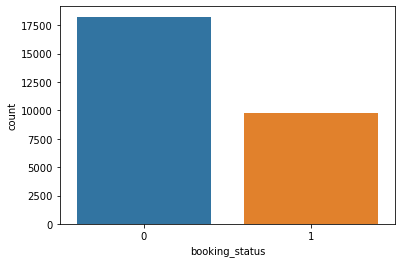

In [38]:
sns.countplot(data=sample_submission, x=TARGET)

In [39]:
all_cv_scores.sort_values(by=["Score"], ascending=False)

,Model,Score,StdDev,RunTime
0,xgb2,0.812989,0.004583,25.937255
2,lgbm1,0.812883,0.003388,10.017185
1,xgb1,0.812504,0.003527,11.624403
3,cat1,0.809759,0.002847,18.984894
